In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm

import os 


In [2]:
# target function eta_0 
def target(x):
    return np.sin(x) - 1/2

eta_0 = target

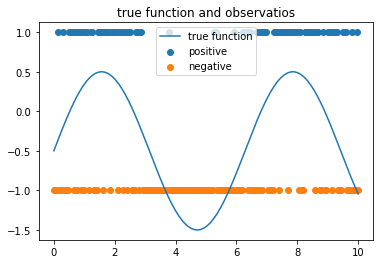

In [155]:
# generate samples
n = 200
x = np.linspace(0,10, n)
np.random.seed(2)
epsilon = np.random.randn(n)
z = eta_0(x) + epsilon
y = (z>0)*1 - 1/2
y1 = [1 if i>0 else None for i in y]
y0 = [-1 if i<0 else None for i in y]
# plt.scatter(x,(-y>0))
plt.scatter(x,y1,label = 'positive')
plt.scatter(x,y0, label = "negative")
plt.plot(x,eta_0(x), label = "true function")
plt.title("true function and observatios")
plt.legend(loc ="best")
plt.show()

In [167]:
def kernel(x,y, tau = 1):
    return np.exp(-(x-y)**2/2)/tau

def construct_sigma(x):
    n = len(x)
    cov = np.ones((n,n))
    for i in range(n):
        for j in range(n):
            cov[i,j] = kernel(x[i],x[j])
    ## make sure cov is positive-definite
    I = np.diag(np.ones_like(x))/len(x)**2
    
    return cov 


def compute_cov(cov):
    # Sigma = P\Lambda P^T
    """
    z,mu: 1-D array
    cov: 2-D array
    """
    n = cov.shape[0]
    lam, p = np.linalg.eig(cov)
    lam = np.diag(lam)
    I = np.diag(np.ones(n))
    cov_post = p.dot(np.linalg.inv(lam+ I)).dot(lam).dot(p.T)
    # mu_post = cov_post.dot(z.reshape(-1,1) - mu.reshape(-1,1)) + mu.reshape(-1,1)
    
    return cov_post 


def matrix_decompose(cov):
    """
    used to speed up the multi-normal generating.
    Input:
    cov: positive-definite matrix
    """
    n = cov.shape[0]
    lam, p = np.linalg.eig(cov)
    lam = (np.real(lam)>0)*lam 
    
    lam = np.diag(lam)

    return p.dot(np.sqrt(lam))

    


class MCMC():
    def __init__(self, x, y, mu, cov, steps) -> None:
        self.x = x 
        self.y = y
        self.mu =mu 
        self.cov = cov
        self.steps = steps
        self.n = len(x) 
    

    def update_z(self, eta):
        y = self.y
        z = np.zeros_like(eta)
        for i in range(len(y)):
            false = True
            while false:
                zi = np.random.normal(eta[i],1)
                false = (zi*y[i] < 0)
            z[i] = zi 
        return z

    def update_eta(self, mean_post, cholesky_post, sd_normal):
        """
        mean_post: shape (dim,1)
        cholesky: shape (dim, dim)
        sd_normal: shape (dim,1)
        """
        eta = mean_post + cholesky_post.dot(sd_normal)
        return eta.reshape(-1)

    def update_eta2(self, mean_post, cov_post):

        return np.random.multivariate_normal(mean_post, cov_post)





    def run(self):
        etas = np.zeros((self.steps, len(self.x)))
        eta = self.mu 
        cov_post = compute_cov(self.cov) #can be complex
        cholesky = matrix_decompose(cov_post)
        sd_normals = np.random.randn(self.steps, self.n)

        for step in tqdm(range(self.steps)):
            # update Z
            z = self.update_z(eta)
            # update eta 
            mu_post = cov_post.dot(z.reshape(-1,1) - self.mu.reshape(-1,1)) + self.mu.reshape(-1,1)
            mu_post = mu_post.reshape(-1)

            eta = self.update_eta(np.real(mu_post).reshape(-1,1), np.real(cholesky), sd_normals[step,:].reshape(-1,1))
            # eta = self.update_eta2(np.real(mu_post), np.real(cov_post))
            etas[step,:] = eta
            

        return etas



    

In [172]:
z = np.random.randn(len(x))
mu = np.zeros_like(x)
cov = construct_sigma(x)
steps = 500
mcmc = MCMC(x, y, mu, cov , steps)
outs = mcmc.run()
# cov_post = compute_cov(cov)
# np.real(cov_post)
# np.linalg.eigh(cov_post)

100%|██████████| 500/500 [00:00<00:00, 505.95it/s]


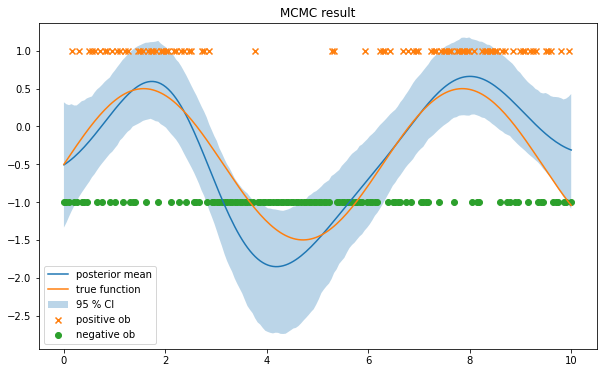

In [171]:
path = os.path.abspath(os.path.join(os.getcwd(), "../../../static/img_reading"))
os.makedirs(path, exist_ok= True)

burning_size = 100
outs_b = outs[burning_size:,:]
eta_up = np.quantile(outs_b,q = 0.975,axis = 0)
eta_down = np.quantile(outs_b,q = 0.025,axis = 0)
plt.figure(figsize=(10,6))
plt.plot(x, outs.mean(axis = 0), label = "posterior mean")
plt.plot(x,eta_0(x), label = "true function")
plt.fill_between(x,eta_down, eta_up, alpha = 0.3, label = "95 % CI")
plt.scatter(x,y1, marker= "x",label = 'positive ob')
plt.scatter(x,y0, marker="o",label = "negative ob")
plt.legend(loc = 'best')
plt.title("MCMC result")



# plt.savefig(path+"\\GP_2c_mcmc.png")
plt.show()

In [220]:
path = os.path.abspath(os.path.join(os.getcwd(), "../../../static/img_rading"))
path

'e:\\Blog\\mathblog\\static\\img_rading'

array([], shape=(0, 200), dtype=float64)